In [243]:
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import math

import numpy as np
from statsmodels.tsa.stattools import adfuller

In this notebook, we are trying to answer whether it is possible to make a tool/model to help the plantation planning team better predict FFB yield from month to month.

# A. DATA PREPARATION

## A.1 Load Data

In [244]:
df = pd.read_csv("palm_ffb.csv")

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 9 columns):
Date             130 non-null object
SoilMoisture     130 non-null float64
Average_Temp     130 non-null float64
Min_Temp         130 non-null float64
Max_Temp         130 non-null float64
Precipitation    130 non-null float64
Working_days     130 non-null int64
HA_Harvested     130 non-null float64
FFB_Yield        130 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.2+ KB


In [246]:
def date_parser(data):
    data_splitted = data.split('.')
    return data_splitted[2]+'-'+data_splitted[1]+'-'+data_splitted[0]

In [247]:
df['date'] = df.apply(lambda x: date_parser(x['Date']),axis=1)
df['date'] = pd.to_datetime(df['date'])

In [248]:
#drop Date column
df.drop(columns=['Date'], inplace=True)

In [249]:
df.tail()

,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield,date
125,498.2,27.213333,21.6,33.6,165.6,24,820758.9147,1.29,2018-06-01
126,494.7,27.074194,21.2,33.5,154.7,26,882254.2254,1.42,2018-07-01
127,478.8,27.016129,20.4,33.6,127.2,25,829488.8199,1.61,2018-08-01
128,481.1,26.946667,21.0,34.2,180.6,23,792101.0471,1.91,2018-09-01
129,510.8,26.819355,21.0,34.4,207.0,26,771805.3922,2.04,2018-10-01


In [250]:
#split data to create data training (Jan 2008 - Oct 2017) and validation (Nov 2017 - Oct 2018)
series = pd.Series(df[:-12]['FFB_Yield'].values, index=df[:-12]['date'])
series.head()

date
2008-01-01    1.62
2008-02-01    1.45
2008-03-01    1.56
2008-04-01    1.39
2008-05-01    1.44
dtype: float64

In [251]:
#validation data is to be used latter
validation = pd.Series(df.tail(12)['FFB_Yield'].values, index=df.tail(12)['date'])
validation.head()

date
2017-11-01    2.27
2017-12-01    2.19
2018-01-01    1.77
2018-02-01    1.39
2018-03-01    1.53
dtype: float64

## A.3 Data Visualization

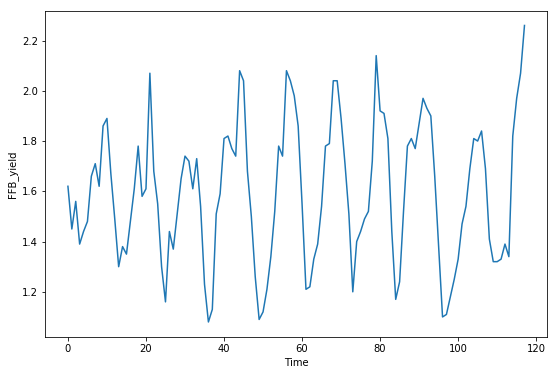

In [252]:
#plot line
plt.figure(figsize=(9,6))
plt.plot(series.values)
plt.ylabel('FFB_yield')
plt.xlabel('Time')
plt.show()

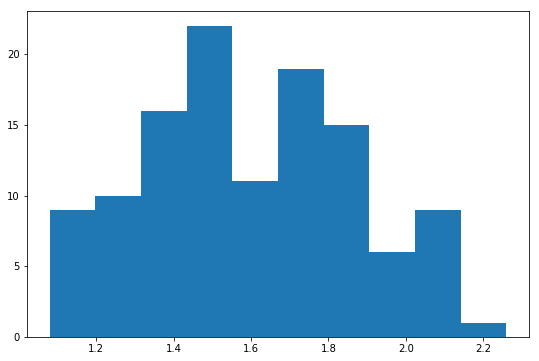

In [253]:
#histogram
plt.figure(figsize=(9,6))
plt.hist(series.values)
plt.show()

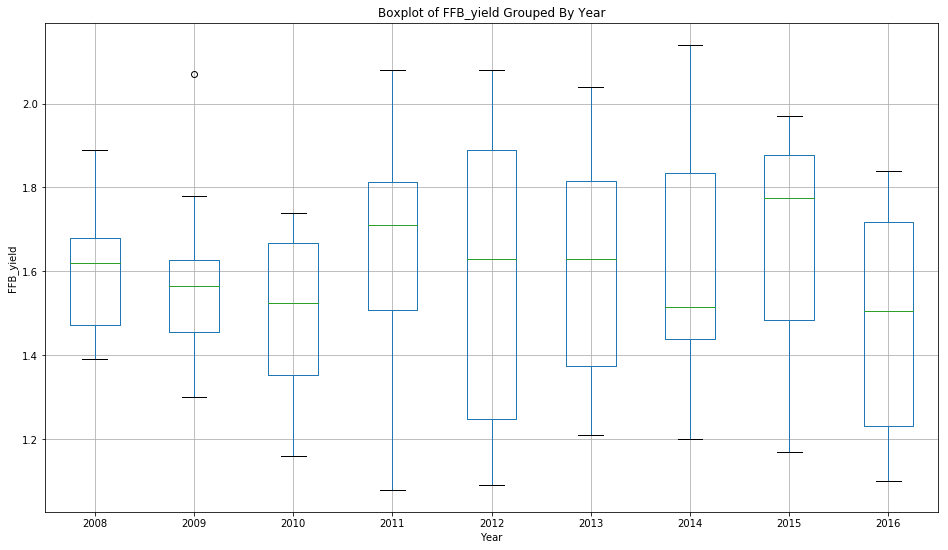

In [254]:
#box plot
from pandas import Grouper

plt.figure(figsize=(16,9))
groups = series['2008':'2016'].groupby(Grouper(freq= 'A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values

years.boxplot()
plt.title('Boxplot of FFB_yield Grouped By Year')
plt.ylabel('FFB_yield')
plt.xlabel('Year')
plt.show()

### Findings
The observations suggest that the year-to-year fluctuations may not be systematic and hard to model. This yearly view of the data is an interesting avenue and could be pursued further by looking at summary statistics from year-to-year and changes in summary stats from year-to-year.

In [255]:
years.describe()

,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,1.612500,1.573333,1.500000,1.645833,1.585000,1.624167,1.625000,1.666667,1.484167
std,0.159381,0.209256,0.200952,0.309793,0.371422,0.296110,0.272847,0.275296,0.282729
min,1.390000,1.300000,1.160000,1.080000,1.090000,1.210000,1.200000,1.170000,1.100000
25%,1.472500,1.455000,1.352500,1.507500,1.247500,1.375000,1.440000,1.485000,1.232500
50%,1.620000,1.565000,1.525000,1.710000,1.630000,1.630000,1.515000,1.775000,1.505000
75%,1.680000,1.627500,1.667500,1.812500,1.890000,1.815000,1.835000,1.877500,1.717500
max,1.890000,2.070000,1.740000,2.080000,2.080000,2.040000,2.140000,1.970000,1.840000


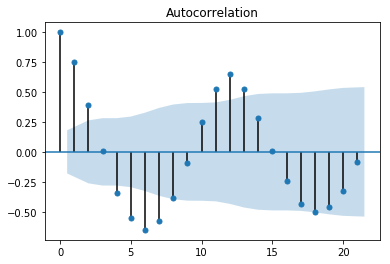

In [256]:
#autocorrelation plot
plot_acf(series)
plt.show()

### Findings 
From the picture above, we can see that the maximum value of p when we use ARIMA is around 13.

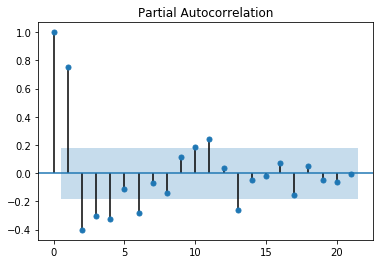

In [257]:
#partial autocorrelation plot
plot_pacf(series)
plt.show()

### Findings 
From the picture above, we can see that the maximum value of q when we use ARIMA is around 6.

## A.4 Resampling (If needed)

In [258]:
#None

# B. ANALYZE TEMPORAL STRUCTURE

## B.1 Is Our Time Series "White Noise"?
If a time series is white noise, it is a sequence of random numbers and cannot be predicted. If the series of forecast errors are not white noise, it suggests improvements could be made to the predictive model.

In [259]:
series.describe()

count    118.000000
mean       1.593475
std        0.275437
min        1.080000
25%        1.382500
50%        1.585000
75%        1.797500
max        2.260000
dtype: float64

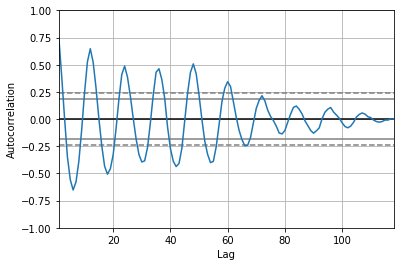

In [260]:
#autocorrelation plot
autocorrelation_plot(series)

### Findings
As you can see that the autocorrelation is not below line and mean is not zero. So the data is not a white noise

## B.2 Is Our Time Series "Random Walk"? (Checking Stationary Also)
Our time series may be a random walk. Some ways to check if our time series is a random
walk are as follows:
<ul>
<li> The time series shows a strong temporal dependence that decays linearly or in a similar
pattern.</li>

<li>The time series is non-stationary and making it stationary shows no obviously learnable
structure in the data.</li>

<li>The persistence / naive forecast model provides the best source of reliable predictions.</li>
</ul>

-------------------


The random walk hypothesis is a theory that the time series are a random walk and cannot be predicted.

In [261]:
# statistical test
result = adfuller(series)
print('ADF statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values: ')
for key, value in result[4].items():
    print('%s: %.3f' %(key,value))
    
    if key == '5%':
        critical_value_5_percent = value

ADF statistic: -3.006622
p-value: 0.034281
Critical values: 
10%: -2.582
5%: -2.889
1%: -3.494


In [262]:
if result[0] < critical_value_5_percent:
    print("Stationary") #or does not have time-dependent structure
else:
    print("Non-Stationary")#or does have time-dependent structure

Stationary


### Findings
It seems that our time series is not a random walk.

## B.3 Decompose Time Series Data

In [263]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [264]:
result_decompose = seasonal_decompose(series, model='multiplicative')

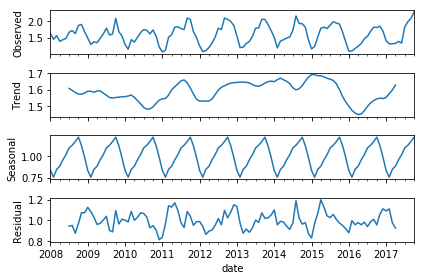

In [265]:
result_decompose.plot()
plt.show()

# C. Evaluate Models

## C.1 Finding Baseline Performance
The simplest forecast that we can make is to forecast that what happened in the previous time
step will be the same as what will happen in the next time step. This is called the _naive forecast
or the persistence forecast model_.

In [266]:
values = pd.DataFrame(series)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [267]:
df.describe()

,t,t+1
count,117.000000,118.000000
mean,1.587778,1.593475
std,0.269550,0.275437
min,1.080000,1.080000
25%,1.380000,1.382500
50%,1.580000,1.585000
75%,1.790000,1.797500
max,2.140000,2.260000


In [268]:
X = df.values
percent_train_size = 50/100
train_size = int(len(X) * percent_train_size)

In [269]:
train, test = X[1:train_size], X[train_size:]

In [270]:
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [271]:
rmse_baseline = math.sqrt(mean_squared_error(test_X, test_y))

In [272]:
rmse_baseline

0.1836171403689975

### Findings
Using _naive forecast model_, we can see that the model achieves an rmse of about 0.184.

We would prefer to build a model that achieves an error that is better than this.

## C.2 Reframe Time Series (If Needed)

In [273]:
#None

# D. Develop Models

## D.1 Creating Models

### D.1.1 Splitting Data

In [274]:
from statsmodels.tsa.arima_model import ARIMA

In [275]:
#split train and test data
X = series.values
X = X.astype('float32')
train, test = X[:train_size], X[train_size:]

### D.1.2 Try Walk Forward Validation with ARIMA

In [276]:
residual_erros = list()

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [277]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order, display_debug=False, display_plot=False):
    global percent_train_size, residual_erros
    
    #emptying
    residual_erros = list()
    
    train_size = int(len(X) * percent_train_size)
    train, test = X[0:train_size], X[train_size:]
    
    history = [x for x in train]
    predictions = list()
    
    if display_debug:
        print('use_transform_data: '+str(use_transform_data))
    
    #walk forward validation
    for t in range(len(test)):
        #difference in data
        months_in_year = 12
        diff = difference(history, months_in_year)
        
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        output = model_fit.forecast()

        yhat = output[0]
            
        yhat = inverse_difference(history, yhat, months_in_year)

        yhat += residual_bias
    
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        
        #additional 1
        if display_debug:
            print('predicted %f, observation %f' %(yhat, obs))

    rmse = math.sqrt(mean_squared_error(predictions, test))
    residual_erros = test - predictions
    
    if display_plot:
        # plot forecasts against actual outcomes
        plt.figure(figsize=(12,6))
        plt.plot(test, label='observations')
        plt.plot(predictions, color= 'red', label='predictions')
        plt.legend()
        plt.show()
            
    return rmse

use_transform_data: False
predicted 1.713220, observation 1.860000
predicted 1.478830, observation 1.550000
predicted 1.306881, observation 1.210000
predicted 1.148939, observation 1.220000
predicted 1.229429, observation 1.330000
predicted 1.371724, observation 1.390000
predicted 1.534393, observation 1.540000
predicted 1.791685, observation 1.780000
predicted 1.725258, observation 1.790000
predicted 2.116388, observation 2.040000
predicted 2.006173, observation 2.040000
predicted 2.002165, observation 1.890000
predicted 1.785031, observation 1.710000
predicted 1.470976, observation 1.510000
predicted 1.196379, observation 1.200000
predicted 1.222463, observation 1.400000
predicted 1.498478, observation 1.440000
predicted 1.459588, observation 1.490000
predicted 1.632612, observation 1.520000
predicted 1.735525, observation 1.720000
predicted 1.746011, observation 2.140000
predicted 2.280454, observation 1.920000
predicted 1.946170, observation 1.910000
predicted 1.895834, observation

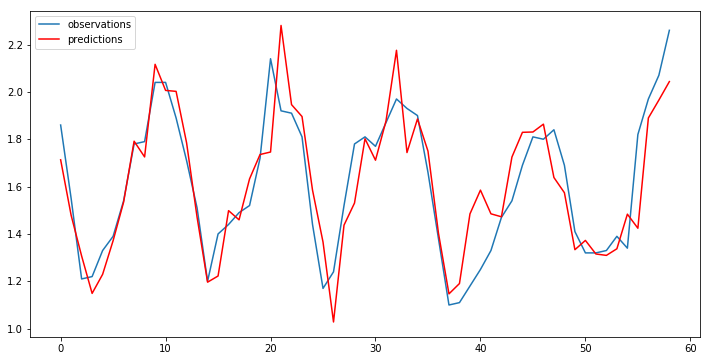

In [278]:
#evaluate model
dataset = series.values
dataset = dataset.astype('float32')
order = (4,0,0)
residual_bias = 0.007752684644020768

rmse_walk_forward = evaluate_arima_model(dataset, order, display_debug=True, display_plot=True)

In [279]:
rmse_walk_forward, rmse_baseline

(0.1479293329219086, 0.1836171403689975)

In [280]:
#betterment
# (1 - rmse_walk_forward/rmse_baseline_transformed_data)*100 #percent, makin tinggi makin baik

In [281]:
model_can_be_optimized = False
if rmse_walk_forward < rmse_baseline:
    print('Good! Our model is better than naive forecast. This model can be further optimized.')
    model_can_be_optimized = True
else:
    print('Ouch... Our model is NOT better than naive forecast. This time series probably a "Random Walk"')

Good! Our model is better than naive forecast. This model can be further optimized.


## D.2 Review Residual Errors (Additional Only)
Ideally, the distribution of residual errors should be a Gaussian with a zero mean

In [282]:
residual_erros

array([ 0.14677997,  0.07116993, -0.09688059,  0.0710606 ,  0.10057074,
        0.01827624,  0.00560697, -0.01168453,  0.06474161, -0.07638818,
        0.03382708, -0.11216533, -0.07503063,  0.03902382,  0.00362135,
        0.17753679, -0.05847836,  0.03041162, -0.11261246, -0.01552478,
        0.39398862, -0.36045446, -0.03617034, -0.08583434, -0.14497432,
       -0.19581007,  0.21172134,  0.08283551,  0.24948497,  0.00792922,
        0.05857014, -0.00682986, -0.20558061,  0.18627142,  0.01441185,
       -0.08991152, -0.02312684, -0.04699399, -0.08058001, -0.30463871,
       -0.33505551, -0.15501547, -0.00250645, -0.18481674, -0.13920846,
       -0.02058228, -0.06367445,  0.20164217,  0.11587847,  0.07645085,
       -0.0527228 ,  0.0046303 ,  0.02051002,  0.05257669, -0.14351671,
        0.39582603,  0.08023058,  0.10464122,  0.2165427 ])

In [283]:
residual_erros.mean()

-3.7634678800852764e-18

In [284]:
pd.DataFrame(residual_erros).describe()

,0
count,5.900000e+01
mean,-3.763468e-18
std,1.491991e-01
min,-3.604545e-01
25%,-8.320717e-02
50%,3.621353e-03
75%,7.381039e-02
max,3.958260e-01


We can see that the distribution has zero mean. This is perhaps a sign that the predictions are not biased. Since we have used this information previously to bias-correct predictions by adding the mean residual error
of 0.007752684644020768 to each forecast made.

## D.3 Optimizing Models (Grid Search)

In [285]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(dataset, order, display_debug=False, display_plot=False)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print("Best ARIMA %s, RMSE =%.3f" % (best_cfg, best_score))

In [286]:
import warnings

In [287]:
p_values = range(0, 6) #10, semakin banyak semakin lama
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")

model_want_to_be_optimized = True

if model_can_be_optimized and model_want_to_be_optimized:
    print('optimizing models starting...')
    evaluate_models(series.values, p_values, d_values, q_values)
else:
    print('Not optimizing models!')

optimizing models starting...
ARIMA(0, 0, 1) RMSE=0.167
ARIMA(0, 1, 1) RMSE=0.158
ARIMA(1, 0, 0) RMSE=0.150
ARIMA(1, 0, 1) RMSE=0.151
ARIMA(1, 1, 0) RMSE=0.158
ARIMA(2, 0, 0) RMSE=0.151
ARIMA(2, 0, 1) RMSE=0.151
ARIMA(2, 1, 0) RMSE=0.158
ARIMA(2, 1, 1) RMSE=0.159
ARIMA(3, 0, 0) RMSE=0.152
ARIMA(3, 0, 1) RMSE=0.152
ARIMA(3, 1, 0) RMSE=0.158
ARIMA(3, 1, 1) RMSE=0.155
ARIMA(4, 0, 0) RMSE=0.148
ARIMA(4, 0, 1) RMSE=0.153
ARIMA(4, 1, 0) RMSE=0.155
ARIMA(4, 1, 1) RMSE=0.154
ARIMA(5, 0, 0) RMSE=0.149
ARIMA(5, 0, 1) RMSE=0.148
ARIMA(5, 1, 0) RMSE=0.157
ARIMA(5, 1, 1) RMSE=0.156
Best ARIMA (4, 0, 0), RMSE =0.148


## D.4 Save/Finalizing Models

Finalizing the model involves fitting an ARIMA model on the entire dataset, in this case, on a
transformed version of the entire dataset. Once fit, the model can be saved to file for later use.

In [288]:
#prepare data
X = series.values
X = X.astype('float32')

# difference data
months_in_year = 12
diff = difference(X, months_in_year)

# make model
best_cfg = (4, 0, 0)
model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=0)

# save model to file
model_fit.save('model_ffb.pkl')
np.save('ffb_bias.npy', [residual_bias])

# E. Predicting

In [289]:
from statsmodels.tsa.arima_model import ARIMAResults

In [290]:
X = series.values.astype('float32')

In [291]:
test = validation.values

In [292]:
# load model
model_fit = ARIMAResults.load('model_ffb.pkl')
bias = np.load('ffb_bias.npy')

In [293]:
history = [x for x in X]
predictions = list()

months_in_year = 12

#walk forward validation on the test data
for t in range(len(test)):
    diff = difference(history, months_in_year)
    
    # transform
    history_final = history

    model = ARIMA(diff, order=order)
    model_fit = model.fit(disp=0, trend='nc')
    output, stderr, conf = model_fit.forecast()
    
    yhat = output
    
    yhat = inverse_difference(history, yhat, months_in_year)
    yhat += residual_bias
    
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    print('predicted %f, observation %f' %(yhat, obs))

rmse = math.sqrt(mean_squared_error(predictions, test))
residual_erros = test - predictions

predicted 2.136964, observation 2.270000
predicted 1.957665, observation 2.190000
predicted 1.777974, observation 1.770000
predicted 1.527995, observation 1.390000
predicted 1.327221, observation 1.530000
predicted 1.425211, observation 1.450000
predicted 1.402042, observation 1.390000
predicted 1.359547, observation 1.290000
predicted 1.759494, observation 1.420000
predicted 1.651540, observation 1.610000
predicted 1.816855, observation 1.910000
predicted 2.114965, observation 2.040000


In [294]:
rmse

0.14965998974554065

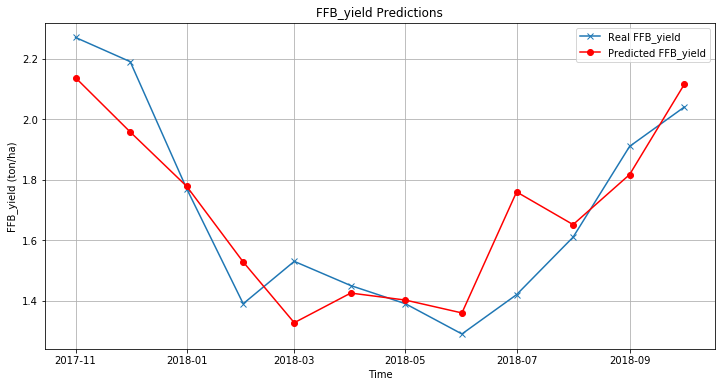

In [296]:
plt.figure(figsize=(12,6))
plt.plot(validation.index, test, label='Real FFB_yield', marker='x')
plt.plot(validation.index, predictions, color= 'red', label='Predicted FFB_yield', marker='o')
plt.xlabel('Time')
plt.ylabel('FFB_yield (ton/ha)')
plt.title('FFB_yield Predictions')
plt.grid()
plt.legend()
plt.show()

### Findings
Perhaps this model can help the plantation planning teams, who are concerned with oil palm yields, to better predict FFB yields from month to month.